In [31]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


devNumber = torch.cuda.current_device()
devName = torch.cuda.get_device_name(devNumber)
print(f"Using device: {device}")
print(f"Current device number is: {devNumber}")
print(f"GPU name is: {devName}")


Using device: cuda
Current device number is: 0
GPU name is: NVIDIA GeForce RTX 4070 SUPER


Epoch [1/20], Train Loss: 1.5444, Val Loss: 1.2157, Val Accuracy: 0.5637
Epoch [2/20], Train Loss: 1.0835, Val Loss: 1.0024, Val Accuracy: 0.6417
Epoch [3/20], Train Loss: 0.8668, Val Loss: 0.8976, Val Accuracy: 0.6877
Epoch [4/20], Train Loss: 0.7163, Val Loss: 0.8591, Val Accuracy: 0.7021
Epoch [5/20], Train Loss: 0.5913, Val Loss: 0.8023, Val Accuracy: 0.7357
Epoch [6/20], Train Loss: 0.4845, Val Loss: 0.8110, Val Accuracy: 0.7399
Epoch [7/20], Train Loss: 0.3892, Val Loss: 0.8844, Val Accuracy: 0.7433
Epoch [8/20], Train Loss: 0.3109, Val Loss: 0.9754, Val Accuracy: 0.7450
Epoch [9/20], Train Loss: 0.2497, Val Loss: 1.0544, Val Accuracy: 0.7393
Epoch [10/20], Train Loss: 0.2044, Val Loss: 1.1341, Val Accuracy: 0.7411
Epoch [11/20], Train Loss: 0.1773, Val Loss: 1.1976, Val Accuracy: 0.7411
Epoch [12/20], Train Loss: 0.1563, Val Loss: 1.3224, Val Accuracy: 0.7364
Epoch [13/20], Train Loss: 0.1513, Val Loss: 1.3372, Val Accuracy: 0.7321
Epoch [14/20], Train Loss: 0.1372, Val Loss: 1.

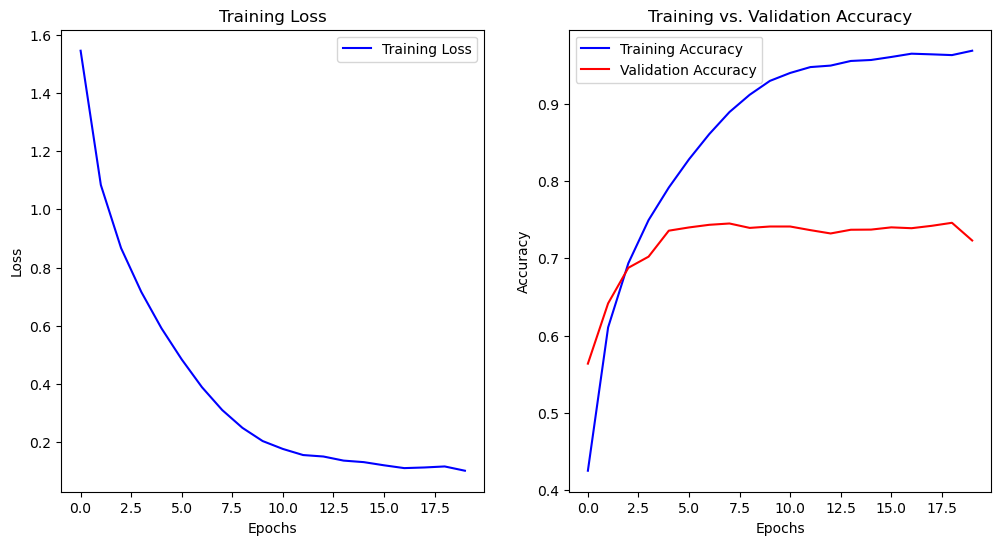


Final Test Accuracy: 0.7230
Precision: 0.7308
Recall: 0.7230
F1 Score: 0.7242


In [ ]:
# Problem 1: Simplified Alexnet model CIFAR-10 (No dropout)
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),  # Resize to match CIFAR-10 (already 32x32)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the AlexNet model
class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  
            nn.ReLU(),
            
            nn.Linear(4096, 4096),
            nn.ReLU(),
           
            nn.Linear(4096, num_classes)  
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function with validation loss tracking
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []  
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time


# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 1.5695, Val Loss: 1.3264, Val Accuracy: 0.5135
Epoch [2/20], Train Loss: 1.1277, Val Loss: 0.9972, Val Accuracy: 0.6583
Epoch [3/20], Train Loss: 0.9351, Val Loss: 0.8822, Val Accuracy: 0.6967
Epoch [4/20], Train Loss: 0.8114, Val Loss: 0.8294, Val Accuracy: 0.7122
Epoch [5/20], Train Loss: 0.7228, Val Loss: 0.8020, Val Accuracy: 0.7318
Epoch [6/20], Train Loss: 0.6507, Val Loss: 0.8574, Val Accuracy: 0.7217
Epoch [7/20], Train Loss: 0.5971, Val Loss: 0.8131, Val Accuracy: 0.7315
Epoch [8/20], Train Loss: 0.5415, Val Loss: 0.7953, Val Accuracy: 0.7438
Epoch [9/20], Train Loss: 0.4995, Val Loss: 0.8131, Val Accuracy: 0.7452
Epoch [10/20], Train Loss: 0.4572, Val Loss: 0.8330, Val Accuracy: 0.7463
Epoch [11/20], Train Loss: 0.4278, Val Loss: 0.8158, Val Accuracy: 0.7413
Epoch [12/20], Train Loss: 0.3983, Val Loss: 0.8540, Val Accuracy: 0.7431
Epoch [13/20], Train Loss: 0.3671, Val Loss: 0.9102, Val Accuracy: 0.7446
Epoch [14/20], Train Loss: 0.3510, Val Loss: 0.

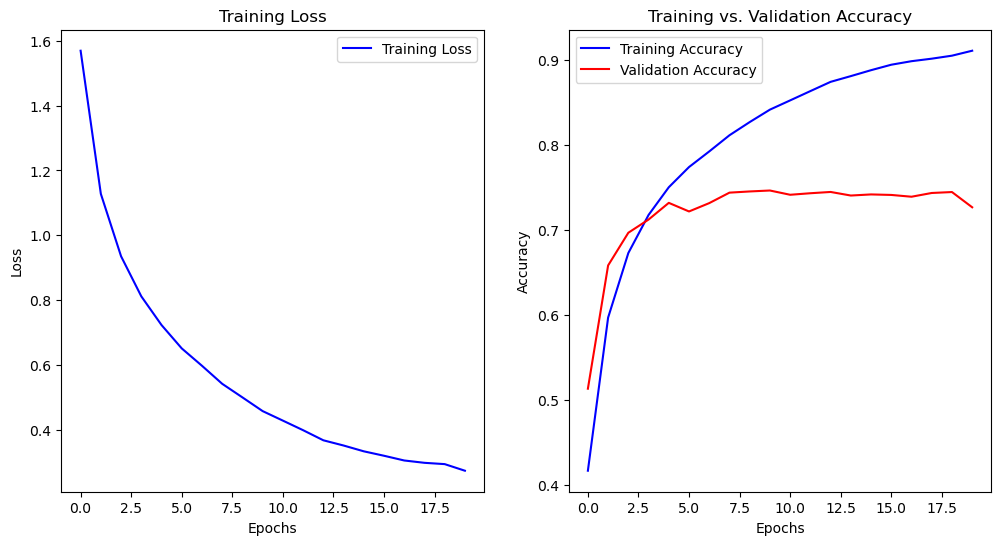


Final Test Accuracy: 0.7266
Precision: 0.7436
Recall: 0.7266
F1 Score: 0.7300


In [ ]:
# Problem 1: Simplified Alexnet model CIFAR-10 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the AlexNet model
class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 4.0717, Val Loss: 3.6863, Val Accuracy: 0.1173
Epoch [2/20], Train Loss: 3.4053, Val Loss: 3.1767, Val Accuracy: 0.2196
Epoch [3/20], Train Loss: 2.9697, Val Loss: 2.8800, Val Accuracy: 0.2789
Epoch [4/20], Train Loss: 2.6412, Val Loss: 2.7006, Val Accuracy: 0.3215
Epoch [5/20], Train Loss: 2.3435, Val Loss: 2.5729, Val Accuracy: 0.3497
Epoch [6/20], Train Loss: 2.0572, Val Loss: 2.5400, Val Accuracy: 0.3640
Epoch [7/20], Train Loss: 1.7587, Val Loss: 2.6511, Val Accuracy: 0.3599
Epoch [8/20], Train Loss: 1.4448, Val Loss: 2.8162, Val Accuracy: 0.3669
Epoch [9/20], Train Loss: 1.1320, Val Loss: 3.1293, Val Accuracy: 0.3679
Epoch [10/20], Train Loss: 0.8621, Val Loss: 3.5015, Val Accuracy: 0.3623
Epoch [11/20], Train Loss: 0.6326, Val Loss: 4.1190, Val Accuracy: 0.3522
Epoch [12/20], Train Loss: 0.4896, Val Loss: 4.6454, Val Accuracy: 0.3463
Epoch [13/20], Train Loss: 0.4120, Val Loss: 5.1610, Val Accuracy: 0.3516
Epoch [14/20], Train Loss: 0.3606, Val Loss: 5.

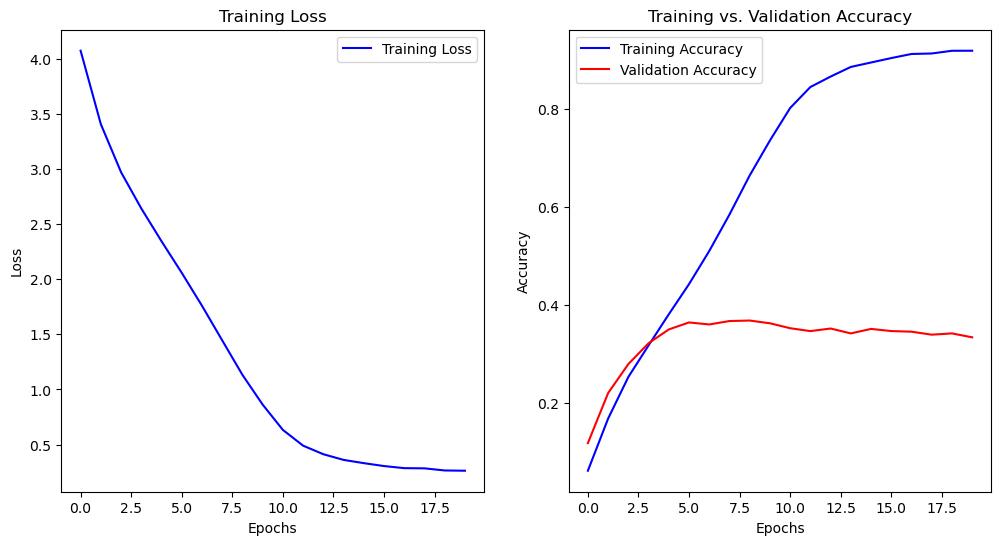


Final Test Accuracy: 0.3336
Precision: 0.3479
Recall: 0.3336
F1 Score: 0.3337


In [ ]:
# Problem 1: Simplified Alexnet model CIFAR-100 (without dropout)
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)  
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)



print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 4.1180, Val Loss: 3.7177, Val Accuracy: 0.1177
Epoch [2/20], Train Loss: 3.5810, Val Loss: 3.3007, Val Accuracy: 0.1943
Epoch [3/20], Train Loss: 3.2293, Val Loss: 3.0343, Val Accuracy: 0.2486
Epoch [4/20], Train Loss: 2.9895, Val Loss: 2.8886, Val Accuracy: 0.2758
Epoch [5/20], Train Loss: 2.8025, Val Loss: 2.7653, Val Accuracy: 0.3018
Epoch [6/20], Train Loss: 2.6529, Val Loss: 2.6586, Val Accuracy: 0.3273
Epoch [7/20], Train Loss: 2.5153, Val Loss: 2.5711, Val Accuracy: 0.3434
Epoch [8/20], Train Loss: 2.3969, Val Loss: 2.5335, Val Accuracy: 0.3550
Epoch [9/20], Train Loss: 2.3026, Val Loss: 2.5066, Val Accuracy: 0.3624
Epoch [10/20], Train Loss: 2.2025, Val Loss: 2.4631, Val Accuracy: 0.3712
Epoch [11/20], Train Loss: 2.1165, Val Loss: 2.4476, Val Accuracy: 0.3755
Epoch [12/20], Train Loss: 2.0322, Val Loss: 2.4335, Val Accuracy: 0.3794
Epoch [13/20], Train Loss: 1.9621, Val Loss: 2.4432, Val Accuracy: 0.3785
Epoch [14/20], Train Loss: 1.8810, Val Loss: 2.

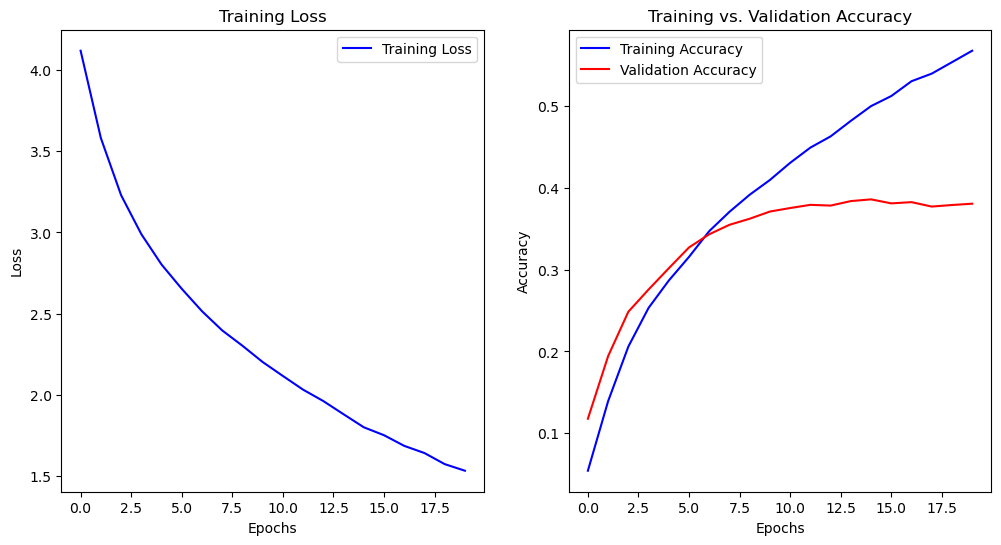


Final Test Accuracy: 0.3808
Precision: 0.4006
Recall: 0.3808
F1 Score: 0.3796


In [ ]:
# Problem 1: Simplified Alexnet model CIFAR-100 with dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  # Adjusted for CIFAR-10 image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)  # Output layer for CIFAR-10
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/2], Train Loss: 1.6116, Val Loss: 1.2110, Val Accuracy: 0.5619
Epoch [2/2], Train Loss: 1.1001, Val Loss: 0.9870, Val Accuracy: 0.6530

Training Time: 38.03 seconds


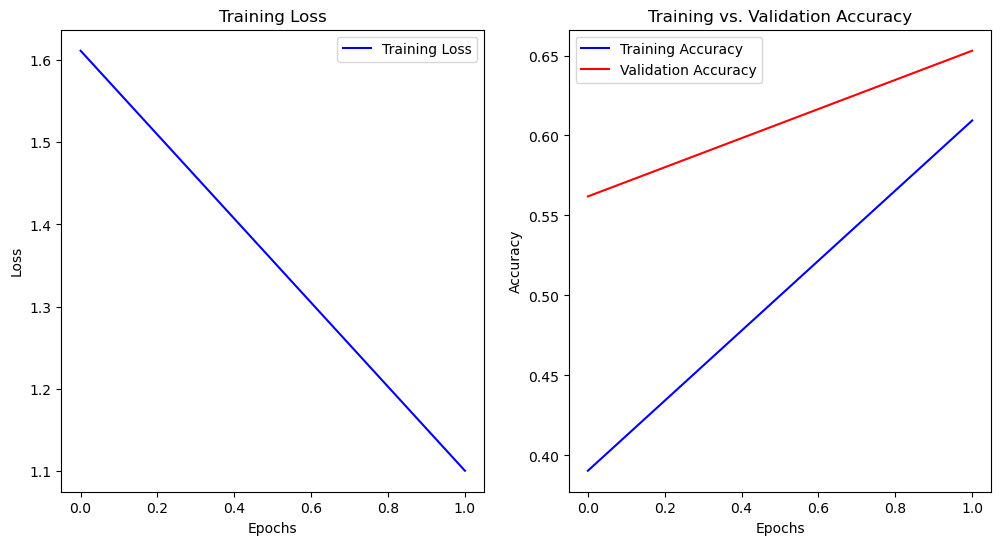


Final Test Accuracy: 0.6530
Precision: 0.6644
Recall: 0.6530
F1 Score: 0.6528


In [ ]:
# Problem 2: Simplified VGGnet model CIFAR-10 no Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 2
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Problem 2: Simplified VGGnet model CIFAR-10 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 2
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Problem 2: Simplified VGGnet model CIFAR-100 no Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 2
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Problem 2: Simplified VGGnet model CIFAR-100 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 2
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [37]:
# Problem 3: Simplified VGGnet model CIFAR-10 with Dropout
batch_size = 64
learning_rate = 0.001
num_epochs = 2
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Resnet Block
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

# ResNet-18 Model
class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )


# Initialize model, loss function, and optimizer
model = ResNet18(image_channels=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
